**Abstract:**
The Pest Prediction in Agriculture project uses artificial intelligence to help farmers spot harmful pests early. Pests can seriously damage crops, reducing the amount of food produced and causing money losses. This tool looks at crop images and other related information to predict when and where pest attacks might happen. By getting an early warning, farmers can take the right steps—

Before using our pest prediction tool, make sure to run the notebook step by step from top to bottom. If you have access to a GPU (a faster computer processor), it will help the model run quicker. We've also added an easy-to-use interface where you can try out the model by uploading your own images. Your ideas and suggestions to make this tool even better are always welcome. Let’s work together to make farming smarter and stronger. Here's to healthier crops and better harvests!



**Import Librarires**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import tempfile


# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Resizing,Rescaling,InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB4
import tensorflow_probability as tfp
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast



# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

**Data Loading**

In [ ]:
data='/kaggle/input/agricultural-pests-image-dataset'
class_name=["ants",'bees','beetle','catterpillar','earthworms','earwig','grasshopper','moth','slug','snail','wasp','weevil']

In [ ]:
configuration={'batchsize':32,'img_size':256,
               'learningrate':0.001,
               'n_epoches':12,
               "num_classes":12,
               'droupoutrate':0.0,
               'regularization_rate':0.0 ,
               'num_filters':6,
               "kernelsize":3,
               "n_strides":1,
               'poolsize':2,
               'N_DENSE_1':100,
               'N_DENSE_2':10,
}

In [ ]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(data)


In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
def save_images_from_df(image_df, output_dir):
    for index, row in image_df.iterrows():
        filepath = row['Filepath']
        label = row['Label']

        image = cv2.imread(filepath)
        output_subdir = os.path.join(output_dir, label)
        os.makedirs(output_subdir, exist_ok=True)

        output_filepath = os.path.join(output_subdir, os.path.basename(filepath))
        cv2.imwrite(output_filepath, image)

# Provide the DataFrame and the output directory
train_data='train '
train_data = save_images_from_df(train_df, train_data)  # Change this to your desired output directory

test_directory = 'test'
save_images_from_df(test_df, test_directory )

In [ ]:
train_data='/kaggle/working/train '

In [ ]:
test_data='/kaggle/working/test'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',     # Create a dataset for the training subset
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
    validation_split=0.15,  # Use 20% of the data for validation
    subset='validation',   # Create a dataset for the validation subset
)


Found 4395 files belonging to 12 classes.
Using 3516 files for training.
Found 4395 files belonging to 12 classes.
Using 659 files for validation.


In [ ]:

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='rgb',
    batch_size=configuration['batchsize'],
    image_size=(configuration['img_size'], configuration['img_size']),
    shuffle=True,
    seed=99,
)


Found 1099 files belonging to 12 classes.


# **Data Visualization**

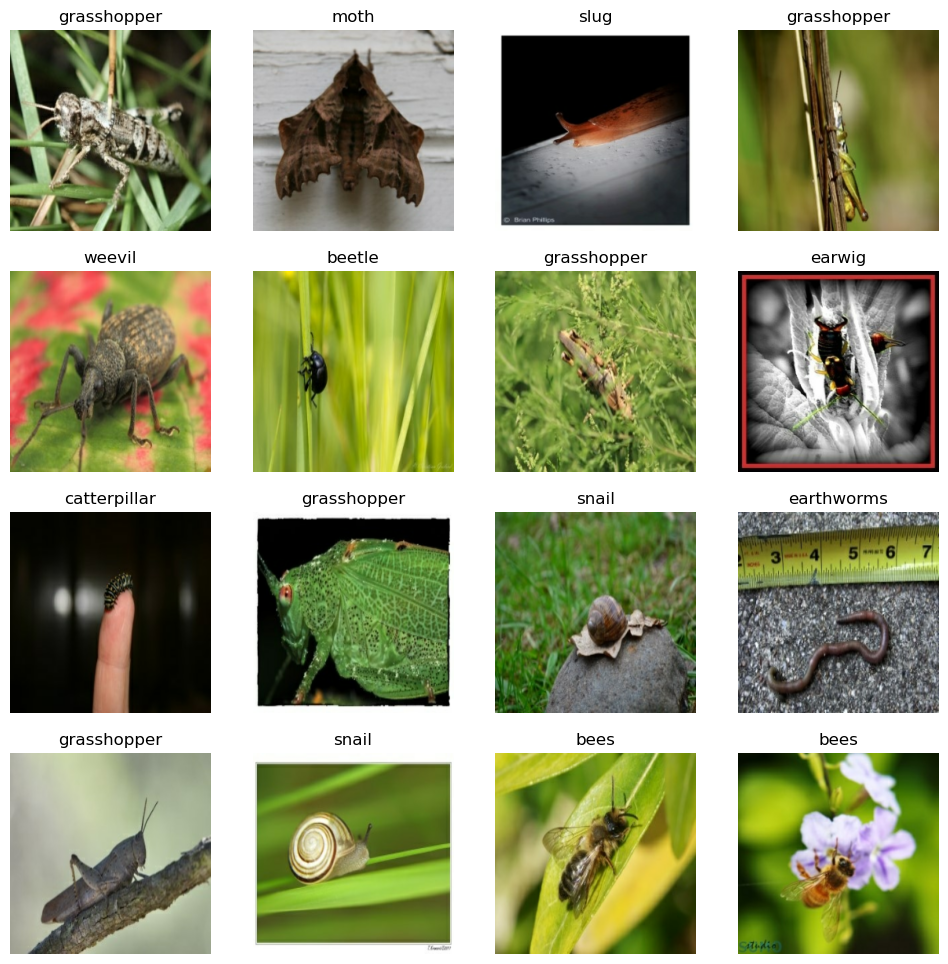

In [ ]:
plt.figure(figsize=(12,12))
for   images,labels in  train_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)
   plt.imshow(images[i]/255.)
   plt.title(class_name[tf.argmax(labels[i],axis=0).numpy()])
   plt.axis("off")



In [ ]:
vali_dataset=(
   val_dataset
    .prefetch(tf.data.AUTOTUNE)


)

In [ ]:
resize_rescale=tf.keras.Sequential(
    Resizing(configuration['img_size'],configuration['img_size']),
    Rescaling(1./255)
)

## **MODEL**

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB4(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(configuration["img_size"], configuration["img_size"], 3)),


   pretrained_model,
    BatchNormalization(),
    Dense(configuration["N_DENSE_1"], activation="relu",
          kernel_regularizer=L2(configuration['regularization_rate'])),
    BatchNormalization(),
      Dense(configuration["N_DENSE_2"], activation="relu",
          kernel_regularizer=L2(configuration['regularization_rate'])),
     BatchNormalization(),
      Dense(configuration["num_classes"], activation="softmax" )

])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 1792)             17673823  
                                                                 
 batch_normalization (BatchN  (None, 1792)             7168      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               179300    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 batch_normalization_2 (Batc  (None, 10)               4

### **loss**

In [ ]:
loss_funcion=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,

)

In [ ]:

metrics=[CategoricalAccuracy(name= 'accuracy'),TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [ ]:
lenet_model.compile(
    optimizer=Adam(learning_rate=configuration['learningrate']),
                   loss=loss_funcion,
                   metrics=metrics

)

In [ ]:
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

**Data Augmentation**

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25, 0.2501)),
   RandomFlip("horizontal_and_vertical",seed=42),  # Specify a seed for reproducibility
])


In [ ]:
# Define a custom preprocessing function
def process_data(image, label):
    # Apply augmentation layers to the image
 # imag= tf.image.rgb_to_grayscale(image)

 # augmented_imag =  tf.image.random_contrast(
   #  imag, lower=0.1, upper=0.9, seed=42
  #)
  augmented_image=augment_layers(image)
    # Resize the augmented image
  resized_image = tf.image.resize(augmented_image, size=(configuration["img_size"], configuration["img_size"]))

  return resized_image, label

# Apply augmentation and preprocessing to the dataset
training_dataset = (
    train_dataset.
    shuffle(1000)
    .map(partial(process_data),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    #.batch(configuration['batchsize'])
   # .prefetch(tf.data.AUTOTUNE)
)


**CUTMIX**

In [ ]:
IM_SIZE=256
def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(8, IM_SIZE - 8).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x, r_w // 2,configuration['img_size'] - r_w // 2)
    r_y = tf.clip_by_value(r_y, r_h // 2, configuration['img_size'] - r_h // 2)

    x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, configuration['img_size'])
    y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, configuration['img_size'])

    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1

    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1

    return r_y, r_x, r_h, r_w


In [ ]:


def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda_value = lamda.sample(1)[0]

    ry, rx, r_h, r_w = box(lamda_value)

    crop_2 = tf.image.crop_to_bounding_box(image_2, ry, rx, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, ry, rx, configuration['img_size'] ,configuration['img_size'])

    crop_1 = tf.image.crop_to_bounding_box(image_1, ry, rx, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, ry, rx, configuration['img_size'], configuration['img_size'])

    cutmixed_image = image_1 - pad_1 + pad_2


    lamda_value = tf.cast(1 - (r_w * r_h) / (configuration['img_size']*configuration['img_size']), dtype=tf.float32)

    cutmixed_label = lamda_value * tf.cast(label_1, dtype=tf.float32) + (1 - lamda_value) * tf.cast(label_2, dtype=tf.float32)

    return cutmixed_image, cutmixed_label


In [ ]:
train_dataset_1 = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))


In [ ]:
cutmix_dataset = (
    mixed_dataset.
    shuffle(1000)
    .map(partial(cutmix),num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    #.batch(configuration['batchsize'])
)

In [ ]:
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:

history = lenet_model.fit(
        training_dataset,
            epochs=configuration['n_epoches'],
            verbose=1,
            validation_data=vali_dataset
        )




Epoch 1/12


2023-08-08 14:42:14.385860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 66s 309ms/step - loss: 1.2460 - accuracy: 0.7181 - top_k_accuracy: 0.8191 - val_loss: 0.6231 - val_accuracy: 0.8756 - val_top_k_accuracy: 0.9393
Epoch 2/12
110/110 [==============================] - 34s 263ms/step - loss: 0.7964 - accuracy: 0.8481 - top_k_accuracy: 0.9076 - val_loss: 0.4438 - val_accuracy: 0.9074 - val_top_k_accuracy: 0.9530
Epoch 3/12
110/110 [==============================] - 35s 266ms/step - loss: 0.6128 - accuracy: 0.8598 - top_k_accuracy: 0.9261 - val_loss: 0.3738 - val_accuracy: 0.9105 - val_top_k_accuracy: 0.9621
Epoch 4/12
110/110 [==============================] - 34s 254ms/step - loss: 0.4814 - accuracy: 0.8840 - top_k_accuracy: 0.9445 - val_loss: 0.3277 - val_accuracy: 0.9196 - val_top_k_accuracy: 0.9621
Epoch 5/12
110/110 [==============================] - 35s 261ms/step - loss: 0.4048 - accuracy: 0.9059 - top_k_accuracy: 0.9508 - val_loss: 0.3168 - val_accuracy: 0.9181 - val_top_k_accuracy: 0.9636
Epoch 6/12
110/1

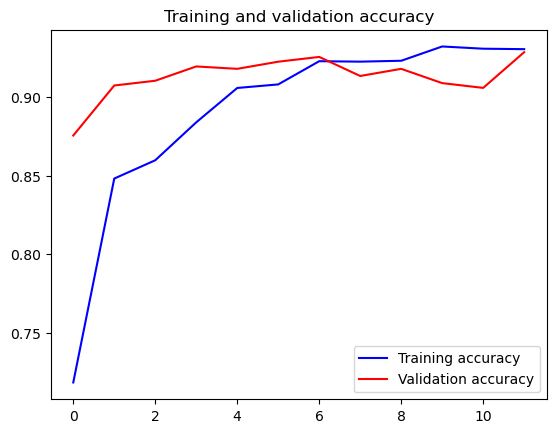

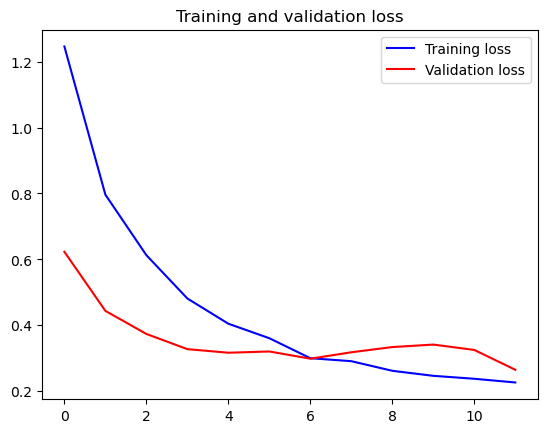

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

Prediction on Test Data

In [ ]:
# Predict the label of the test_images
pred = lenet_model.predict(test_dataset)


35/35 [==============================] - 10s 202ms/step


In [ ]:

lenet_model.evaluate(test_dataset)

35/35 [==============================] - 7s 180ms/step - loss: 0.3273 - accuracy: 0.9163 - top_k_accuracy: 0.9600


[0.3273426294326782, 0.9162875413894653, 0.9599636197090149]

In [ ]:
predicted=[]
labels=[]
for im, label in test_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [ ]:
pred= np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab= np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

[[ 93   0   0   0   0   1   0   0   0   0   0   0]
 [  0  88   0   0   0   0   0   0   0   0   4   0]
 [  1   3  71   4   0   2   5   0   2   0   1   5]
 [  0   3   2  68   4   4   3   0   0   0   1   0]
 [  1   0   0   4  55   1   2   1   2   1   0   0]
 [  0   1   7   6   2  68   3   2   0   0   0   0]
 [  0   0   0   2   0   1 102   0   0   0   0   0]
 [  0   0   1   0   0   0   1  97   0   0   0   0]
 [  0   0   0   3   0   0   0   0  71   2   0   0]
 [  0   0   0   0   0   0   0   0   1 101   0   0]
 [  0   1   0   0   0   2   0   0   0   0 101   0]
 [  0   0   0   0   0   0   0   0   0   0   0  92]]


Text(0.5, 58.7222222222222, 'Predicted')

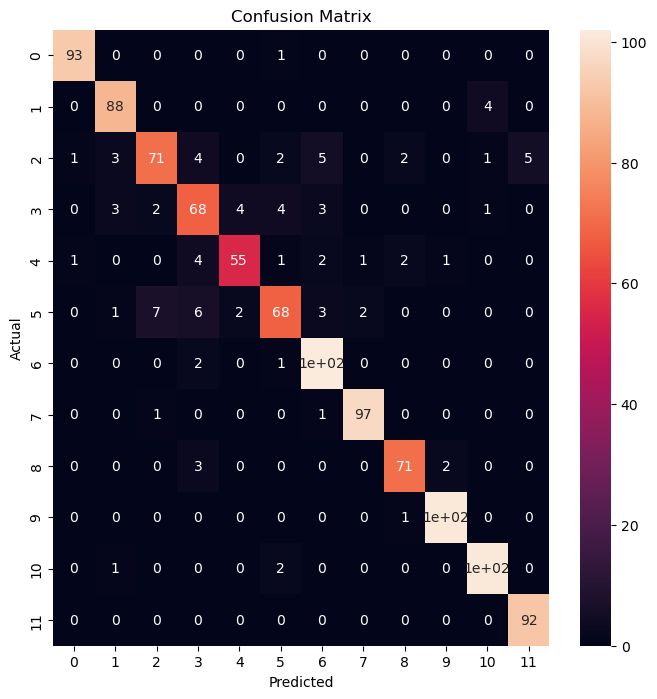

In [ ]:
cm=confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel("Predicted")

**Visualizing**

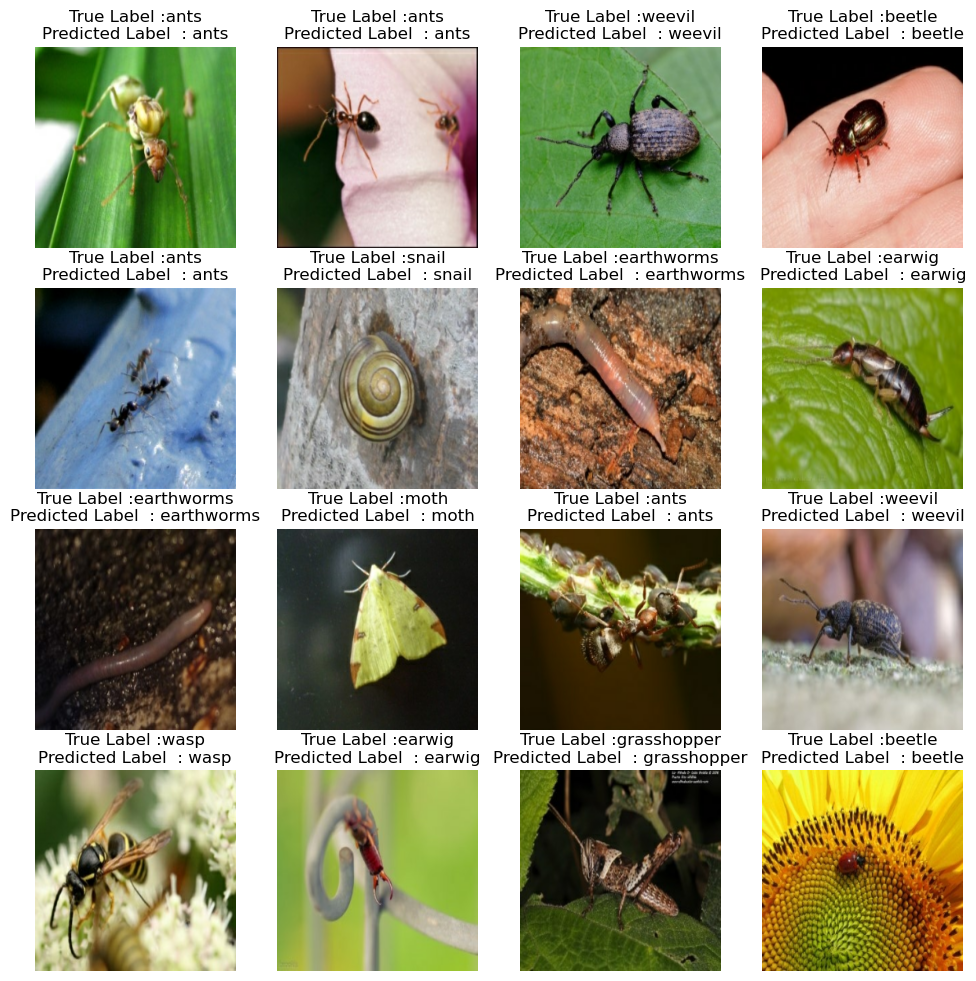

In [ ]:
plt.figure(figsize=(12,12))
for   images,labels in  test_dataset.take(10):
  for i   in range(16):
   ax=plt.subplot(4,4,i+1)

   plt.imshow(images[i]/255.)
   plt.title("True Label :"+ class_name[tf.argmax(labels[i],axis=0).numpy()] + "\n" + "Predicted Label  : " + class_name[tf.argmax(lenet_model(tf.expand_dims(images[i],axis=0)),axis= -1).numpy()[0]])
   plt.axis("off")

In [ ]:
from PIL import Image
def predicts(image_array):
      # Create a temporary directory
    temp_dir = tempfile.mkdtemp()

    # Define the file path for saving the image
    image_path = os.path.join(temp_dir, 'temp_image.jpg')  # Change the file format if needed

    # Save the image using OpenCV
    cv2.imwrite(image_path, image_array)
    test_img=Image.open(image_path)
    test_img=tf.image.resize(test_img, size=(configuration["img_size"], configuration["img_size"]))
    im=tf.constant(test_img,dtype=tf.float32)
    im=tf.expand_dims(im,axis=0)
    result=class_name[tf.argmax(lenet_model(im),axis= -1).numpy()[0]]
    return result.upper()

**UI**

In [ ]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5596 sha256=4345f7122549afd81ecc39b612043a5f07fb9135511db03468e04652f23463fa
  Stored in directory: /root/.cache/pip/wheels/01/a6/d1/1c0828c304a4283b2c1639a09ad86f83d7c487ef34c6b4a1bf
Successfully built ffmpy
  Attempting uninstall: mdit-py-plugins
    Found existing installation: mdit-py-plugins 0.4.0
    Uninstalling mdit-py-plugins-0.4.0:
      Successfully uninstalled mdit-py-plugins-0.4.0


In [ ]:
import gradio as gr

In [ ]:
iface=gr.Interface(fn=predicts, inputs='image',outputs='text')
iface.launch()

Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://fd43b9d4a0f62aa511.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
